<font face = "Times New Roman">

Importing the Drive Contents to save all the files.

Datasets are saved in the drive folder, so to access it.

</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "drive/"
%cd "MyDrive/"
!pwd
%cd "SRCNN_FDPL_sdv4/"
# %ls -l

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive
[Errno 2] No such file or directory: 'SRCNN_FDPL_sdv4/'
/content/drive/MyDrive


<font face = "Times New Roman">

Navigating to the directory where all the relevant folders and files are stored

</font>

In [ ]:
%cd "/content/drive/MyDrive/ML/Project-SRCNN/SRCNN_FDPL_sdv4/"
# %cd "MyDrive/SRCNN_FDPL_sdv4"
# % ls -l
# %cd "/drive/Sharedwithme/ML/Project-SRCNN/SRCNN_FDPL_sdv4/"

/content/drive/MyDrive/ML/Project-SRCNN/SRCNN_FDPL_sdv4


In [ ]:
# ls -l

<font face = "Times New Roman">

Requirements:
1.   Math
2.   Shutil
3.   Scipy 
4. Matplotlib
5. Numpy
6. PIL
7. skimimage
8. PyTorch
9. TorchVision
10. CUDA (GPU)

Importing all the libraries and necessary packages to run the ML model.

</font>

In [ ]:
import os
import sys
import random
# To add the system path to the drive folder for accessing the drive items
sys.path.append('../') 

import shutil
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import transforms
from torchvision import datasets

<font face = "Times New Roman">

Initialise the GPU device for the program (subject to availability) and setting it as the default device

</font>

In [ ]:
# If we have a GPU, use it else CPU
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") 
evaluate_model.DEVICE = device

NameError: ignored

<font face = "Times New Roman">

Initialise the necessary variables

</font>

In [ ]:
# Resolution factor for the interpolation of the distored/blurred images
SR_FACTOR = 3

# Blurring factor by which image is distorted by using the Gaussian Blur
SIGMA = 1.0

<font face = "Times New Roman">

Pre-processing of the training images

Generate target images for training, using train and test set of BSDS500

</font>

In [ ]:
# From the train dataset of BSDS500

# Store all the training images based on their extension
training_img_names = [i for i in os.listdir('./Data/BSDS500/images/train/') if i[-4:] == '.jpg']

# To store the trainining images after the preprocessing
training_images_gt_patches = []

# Iterate through the indices and names of the images
for idx, img_name in enumerate(training_img_names): 

    # Store the images as a file with the name
    ImageFile = Image.open('./Data/BSDS500/images/train/'+img_name)

    # Convert the image from the RGB to the YCbCr color coding with float data-type to give an enhanced color contrast
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 

    # Obtain a 2D matrix of the image for the pre-processing
    im_train_Y = im_train[:,:,0]

    # Crop image to be multiple of 8 in both dimensions
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8

    # As the image is a square any length can be taken as a dimension
    square_dim = min(max_x, max_y)

    # Store the image till it's entire dimension is covered (as a matrix)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]

    # Need to extract to patches so that all images are the same size

    # Iterate through every patch vertically with stride 13    
    for i in range(0, im_train_Y.shape[1]-32, 13):
        for j in range(0, im_train_Y.shape[0]-32, 13):

            # Take the image as 32 * 32 matrices
            sub_im = im_train_Y[j:j+32, i:i+32]

            # Completion of the pre-processing
            # Store the pre-processed images
            training_images_gt_patches.append(sub_im)

In [ ]:
# From the test dataset of BSDS500

# Store all the training images based on their extension
training_img_names = [i for i in os.listdir('./Data/BSDS500/images/test/') if i[-4:] == '.jpg']

# As we are adding the test and training images to the training data, no initialization required
# It is added as a part of the same pre-processed image set

# Iterate through the indices and names of the images
for idx, img_name in enumerate(training_img_names):

    # Store the images as a file with the name    
    ImageFile = Image.open('./Data/BSDS500/images/test/'+img_name)

    # Convert the image from the RGB to the YCbCr color coding with float data-type to give an enhanced color contrast
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 

    # Obtain a 2D matrix of the image for the pre-processing
    im_train_Y = im_train[:, :, 0]

    # Crop image to be multiple of 8 in both dimensions
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8

    # As the image is a square any length can be taken as a dimension
    square_dim = min(max_x, max_y)

    # Store the image till it's entire dimension is covered (as a matrix)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]

    # Need to extract to patches so that all images are the same size

    # Iterate through every patch vertically with stride 13
    for i in range(0, im_train_Y.shape[1]-32, 13):
        for j in range(0, im_train_Y.shape[0]-32, 13):

            # Take the image as 32 * 32 matrices
            sub_im = im_train_Y[j:j+32, i:i+32]

            # Completion of the pre-processing
            # Store the pre-processed images            
            training_images_gt_patches.append(sub_im)

<font face = "Times New Roman">

Prepare target training images to be part of dataset

</font>

In [ ]:
# Convert into Numpy array making it mutable, allowing modification easily
training_images_gt_patches = np.array(training_images_gt_patches)

# Check the shape of the images
print(training_images_gt_patches.shape)

# Normalize the images into the standard size of 256 pixels
training_images_gt_patches /= 255.0

# Compute the Mean of the image pixels
train_pixel_mean = np.mean(training_images_gt_patches)
print(train_pixel_mean)

# Compute the Standard Deviation of the image pixels
train_pixel_std = np.std(training_images_gt_patches)
print(train_pixel_std)

# Standardize the images by subtracting Mean and Dividing Standard Deviation
training_images_gt_patches -= train_pixel_mean
training_images_gt_patches /= train_pixel_std

# Build a Tensor out of the images to align with the input of the ML model
training_images_gt_patches = torch.tensor(training_images_gt_patches)

(213716, 32, 32)
0.4341907899317773
0.23161499468707267


<font face = "Times New Roman">

Distortion of the training images

Generate distorted images for training, using train and test set of BSDS500

</font>

In [ ]:
# From the train dataset of BSDS500

# Store all the training images based on their extension
training_img_names = [i for i in os.listdir('./Data/BSDS500/images/train/') if i[-4:] == '.jpg']

# To store the trainining images after the distortion
training_images_training_patches = []

# Iterate through the indices and names of the images
for idx, img_name in enumerate(training_img_names):

    # Store the images as a file with the name
    ImageFile = Image.open('./Data/BSDS500/images/train/'+img_name)

    # Convert the image from the RGB to the YCbCr color coding with float data-type to give an enhanced color contrast
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 

    # Obtain a 2D matrix of the image for the pre-processing
    im_train_Y = im_train[:,:,0]

    # Crop image to be multiple of 8 in both dimension
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8

    # As the image is a square any length can be taken as a dimension
    square_dim = min(max_x, max_y)

    # Breaking the image based on the YCbCr color space

    # First dimension of the image corresponds to the Y Color space
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]

    # Second dimension of the image corresponds to the Cb Color space
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]

    # Third dimension of the image corresponds to the Cr Color space
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # Distort the image with blur, downsize and upsize bicubic interpolation

    # Refer to the documentation of the function in the source file

    # First dimension of the image is blurred with the necessary factors as parameters    
    im_Y_blur = distort_image(path='./Data/BSDS500/images/train/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    # Need to extract to patches so that all images are the same size

    # Iterate through every patch vertically with stride 13 
    for i in range(0, im_Y_blur.shape[1]-32, 13):
        for j in range(0, im_Y_blur.shape[0]-32, 13):

            # Take the image as 32 * 32 matrices
            sub_im = im_Y_blur[j:j+32, i:i+32]

            # Completion of the pre-processing
            # Store the pre-processed images
            training_images_training_patches.append(sub_im)

In [ ]:
# From the test dataset of BSDS500

# Store all the training images based on their extension
training_img_names = [i for i in os.listdir('./Data/BSDS500/images/test/') if i[-4:] == '.jpg']

# As we are adding the test and training images to the training data, no initialization required
# It is added as a part of the same distorted image set

# Iterate through the indices and names of the images
for idx, img_name in enumerate(training_img_names):

    # Store the images as a file with the name
    ImageFile = Image.open('./Data/BSDS500/images/test/'+img_name)

    # Convert the image from the RGB to the YCbCr color coding with float data-type to give an enhanced color contrast
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 

    # Obtain a 2D matrix of the image for the pre-processing
    im_train_Y = im_train[:,:,0]

    # Crop image to be multiple of 8 in both dimension
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8

    # As the image is a square any length can be taken as a dimension
    square_dim = min(max_x, max_y)

    # Breaking the image based on the YCbCr color space

    # First dimension of the image corresponds to the Y Color space
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]

    # Second dimension of the image corresponds to the Cb Color space
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]

    # Third dimension of the image corresponds to the Cr Color space
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]

    # Distort the image with blur, downsize and upsize bicubic interpolation

    # Refer to the documentation of the function in the source file

    # First dimension of the image is blurred with the necessary factors as parameters
    im_Y_blur = distort_image(path='./Data/BSDS500/images/test/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    # Need to extract to patches so that all images are the same size

    # Iterate through every patch vertically with stride 13 
    for i in range(0, im_Y_blur.shape[1]-32, 13):
        for j in range(0, im_Y_blur.shape[0]-32, 13):

            # Take the image as 32 * 32 matrices
            sub_im = im_Y_blur[j:j+32, i:i+32]

            # Completion of the pre-processing
            # Store the pre-processed images
            training_images_training_patches.append(sub_im)

<font face = "Times New Roman">

Check whether the image distortions are reasonable before entering the ML model

</font>

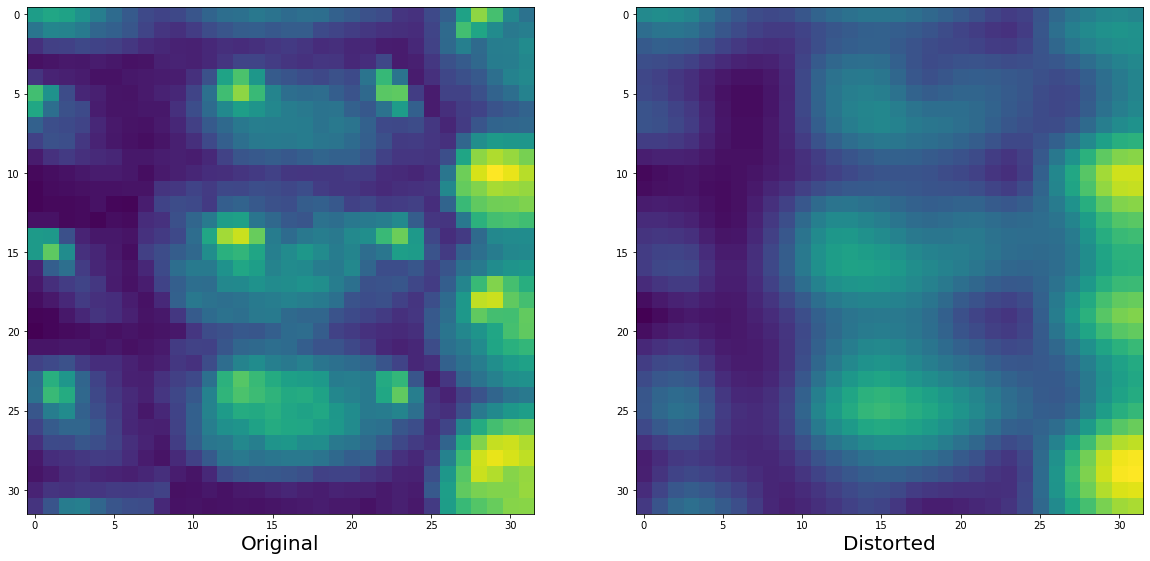

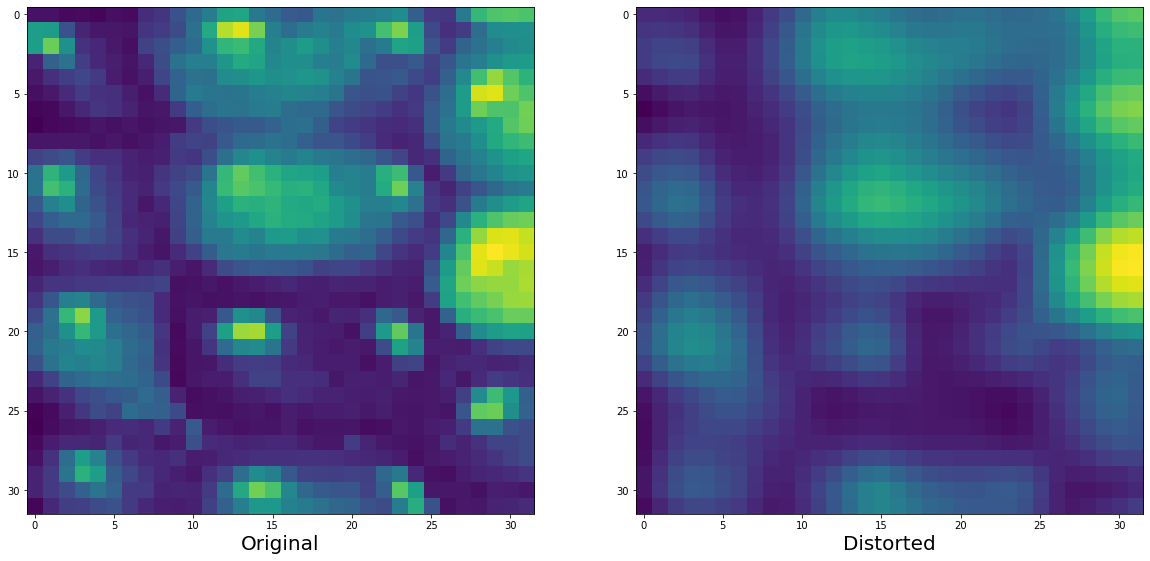

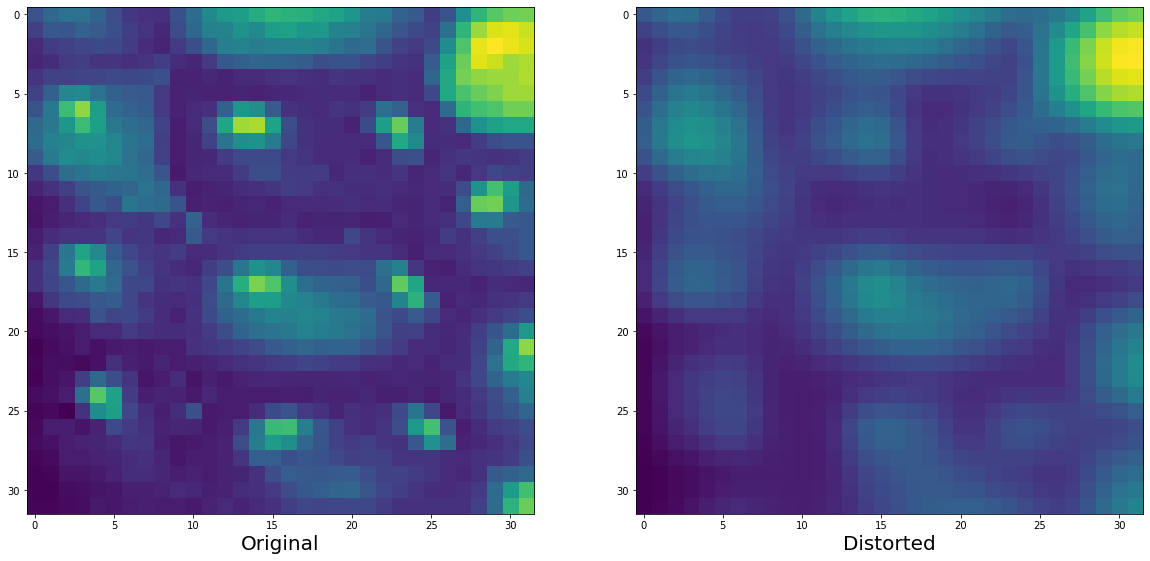

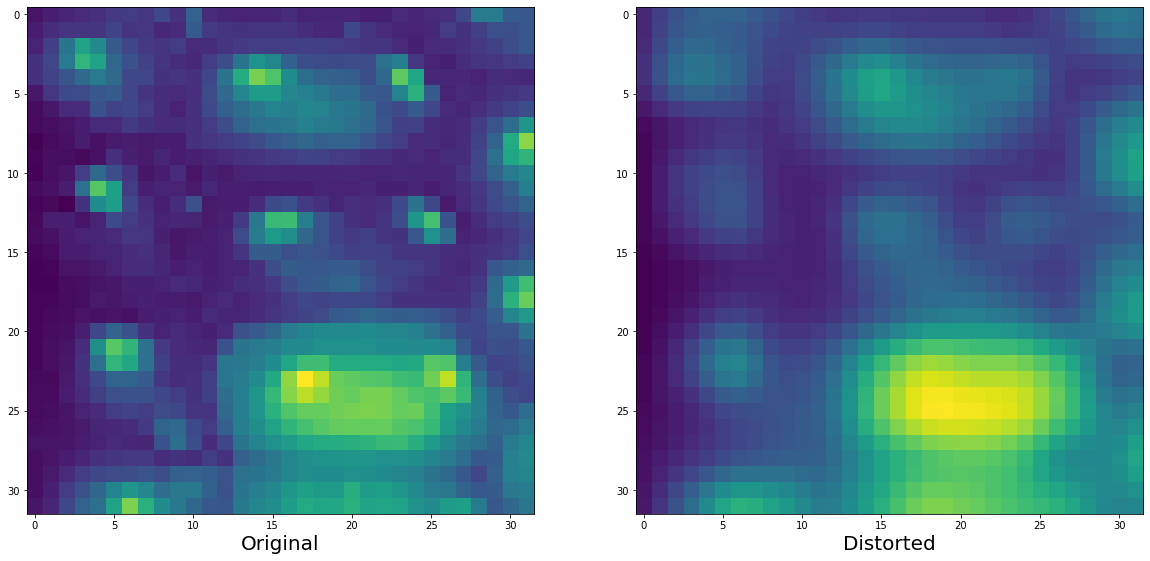

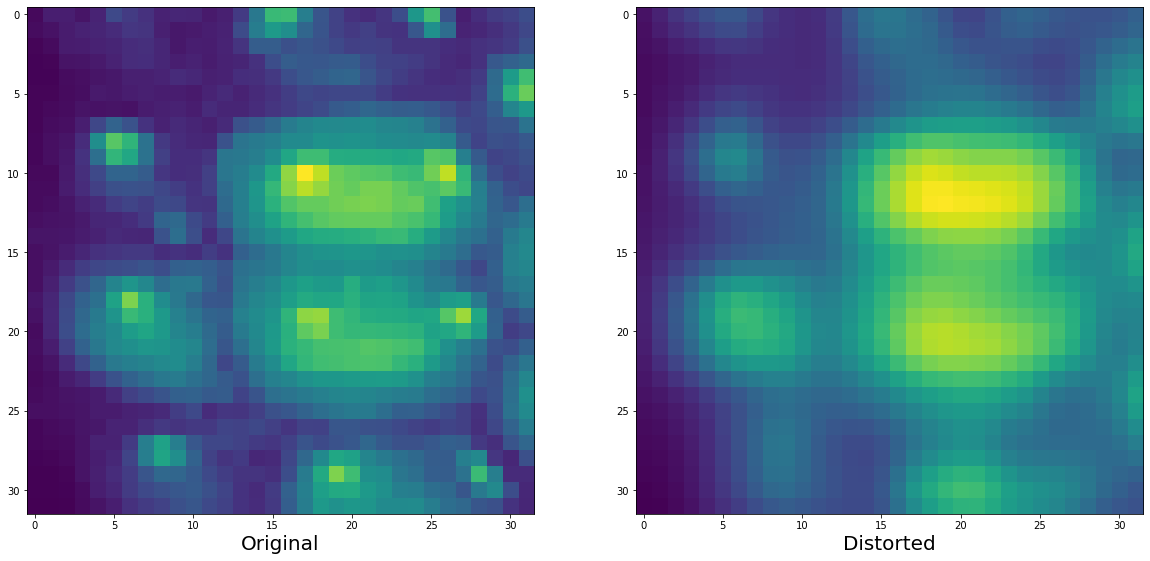

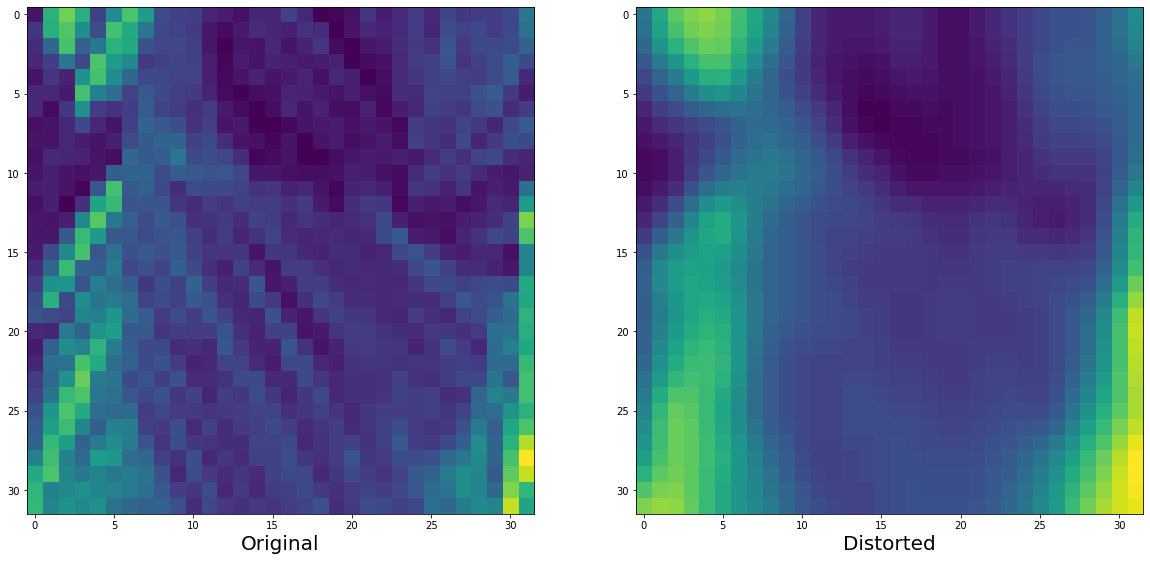

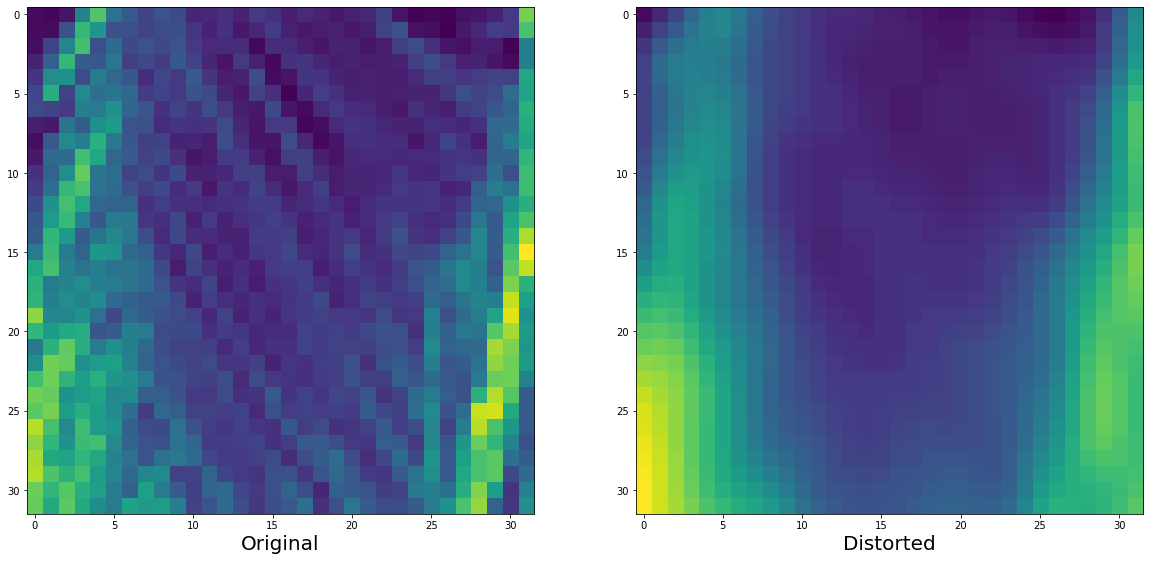

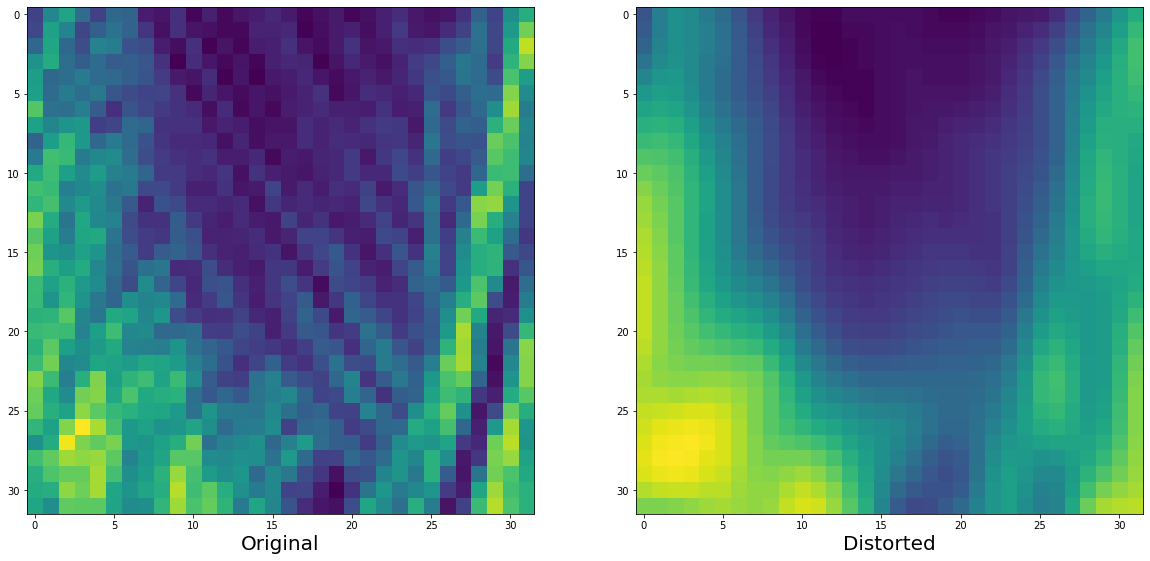

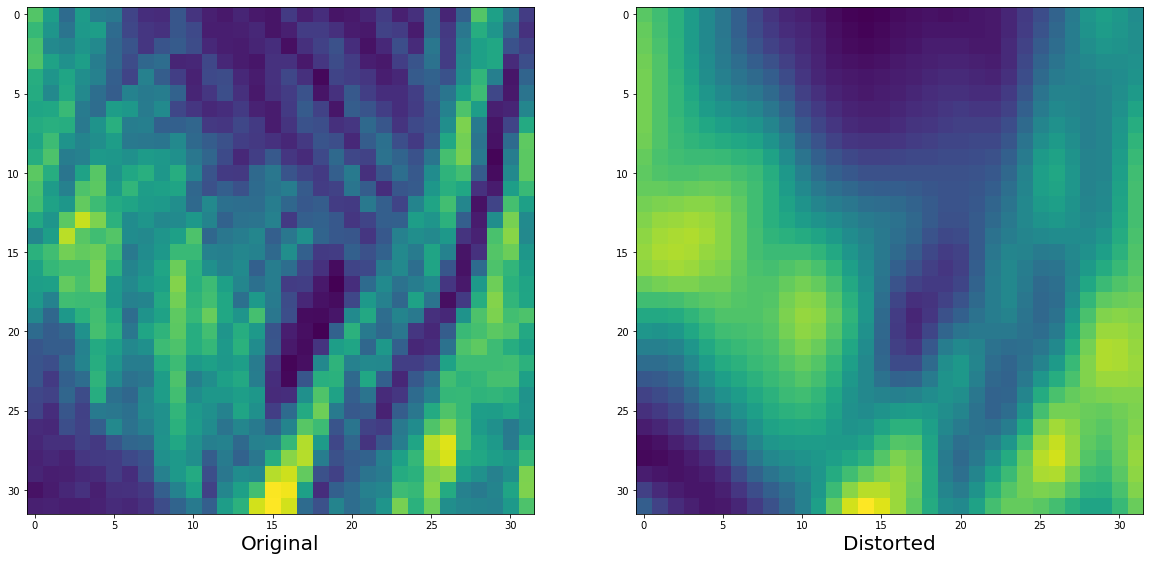

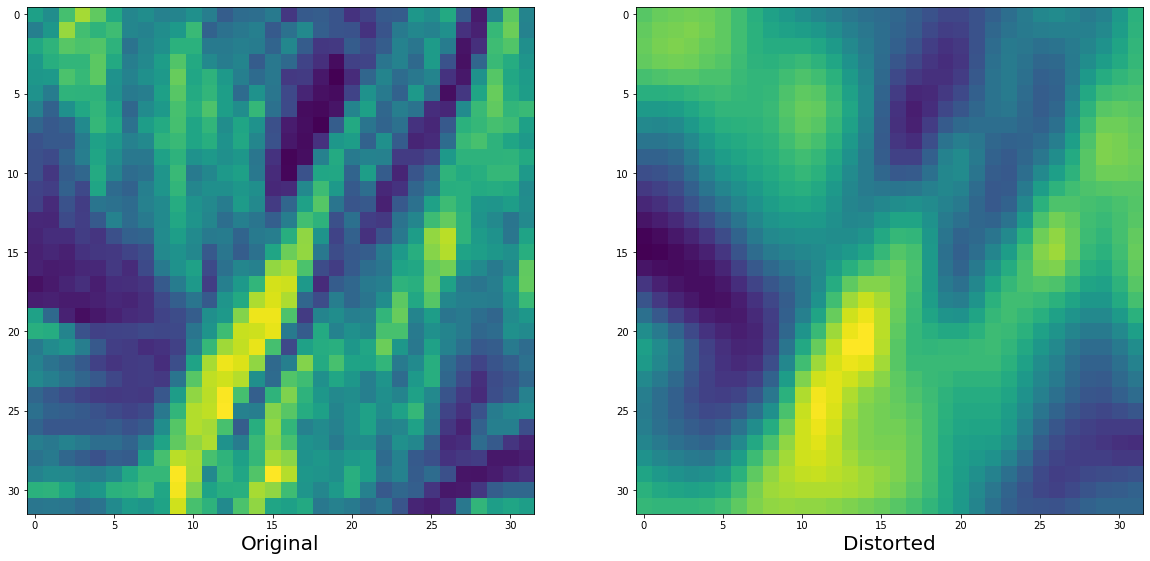

In [ ]:
# Iterate through 10 images and check them
for i in range(10000,10010):

    # Show the original and distorted image

    # Create a subplot of the necessary size    
    f, axarr = plt.subplots(1,2, figsize=(20, 20))

    # Show the original image
    axarr[0].imshow(training_images_gt_patches[i])

    # Add the necessary label
    axarr[0].set_xlabel('Original', fontsize=20)

    # Show the distorted image
    axarr[1].imshow(training_images_training_patches[i])

    # Add the necessary label
    axarr[1].set_xlabel('Distorted', fontsize=20)

<font face = "Times New Roman">

Prepare distorted input training images for use in dataset

</font>

In [ ]:
# Convert into Numpy array making it mutable, allowing modification easily
training_images_training_patches = np.array(training_images_training_patches)

# Check the shape of the images
print(training_images_training_patches.shape)

# Normalize the images into the standard size of 256 pixels
training_images_training_patches /= 255.0

# As the Mean and Standard Deviation have been pre-computed

# Standardize the images by subtracting Mean and Dividing Standard Deviation
training_images_training_patches -= train_pixel_mean
training_images_training_patches /= train_pixel_std

# Build a Tensor out of the images to align with the input of the ML model
training_images_training_patches = torch.tensor(training_images_training_patches)

# Check the shape of the tensor
training_images_training_patches.shape

(213716, 32, 32)


torch.Size([213716, 32, 32])

<font face = "Times New Roman">

Load the Training Data

</font>

In [ ]:
# Build a Tensor Dataset out of the training distorted images and training target images

my_training_dataset = data.TensorDataset(training_images_training_patches, training_images_gt_patches)

# Load the Tensor Dataset by shuffling it into in batches of size 128 images
# Drop the last batch as it might not be of size 128 (it can cause issue because of non-uniform size)
my_dataloader = data.DataLoader(my_training_dataset,
                                batch_size=128,
                                shuffle=True,
                                drop_last=True)

<font face = "Times New Roman">

Pre-processing of the validation images

Generate target images for validation, using validation set of BSDS500

</font>

In [ ]:
# From the validation dataset of BSDS500

# Store all the validation images based on their extension
val_img_names = [img for img in os.listdir('./Data/BSDS500/images/val/') if img[-4:] == '.jpg']

# To store the validation images after the preprocessing
val_images_gt_patches = []

# Iterate through the indices and names of the images
for idx, img_name in enumerate(val_img_names):

    # Store the images as a file with the name
    ImageFile = Image.open('./Data/BSDS500/images/val/'+img_name)

    # Convert the image from the RGB to the YCbCr color coding with float data-type to give an enhanced color contrast
    im_val = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 

    # Obtain a 2D matrix of the image for the pre-processing
    im_val_Y = im_val[:,:,0]

    # Crop image to be multiple of 8 in both dimensions
    max_x = int(im_val_Y.shape[0]/8) * 8
    max_y = int(im_val_Y.shape[1]/8) * 8

    # As the image is a square any length can be taken as a dimension
    square_dim = min(max_x, max_y)

    # Store the image till it's entire dimension is covered (as a matrix)
    im_val_Y = im_val_Y[0:square_dim, 0:square_dim]

    # Need to extract to patches so that all images are the same size

    # Iterate through every patch vertically with stride 13 
    for i in range(0, im_val_Y.shape[1]-32, 13):
        for j in range(0, im_val_Y.shape[0]-32, 13):

            # Take the image as 32 * 32 matrices
            sub_im = im_val_Y[j:j+32, i:i+32]

            # Completion of the pre-processing
            # Store the pre-processed images
            val_images_gt_patches.append(sub_im)

<font face = "Times New Roman">

Prepare target input validation images for use in dataset

</font>

In [ ]:
# Convert into Numpy array making it mutable, allowing modification easily
val_images_gt_patches = np.array(val_images_gt_patches)

# Check the shape of the images
print(val_images_gt_patches.shape)

# Normalize the images into the standard size of 256 pixels
val_images_gt_patches /= 255.0

# As the Mean and Standard Deviation have been pre-computed

# Standardize the images by subtracting Mean and Dividing Standard Deviation
val_images_gt_patches -= train_pixel_mean
val_images_gt_patches /= train_pixel_std

# Build a Tensor out of the images to align with the input of the ML model
val_images_gt_patches = torch.tensor(val_images_gt_patches)

# Check the shape of the tensor
val_images_gt_patches.shape

(52900, 32, 32)


torch.Size([52900, 32, 32])

<font face = "Times New Roman">

Distortion of the validation images

Generate distorted images for validation, using validation set of BSDS500

</font>

In [ ]:
# From the validation dataset of BSDS500

# As we have aldready have the validation images, no re-initialization is required

# To store the distorted validation images
val_images_val_patches = []

# Iterate through the indices and names of the images
for idx, img_name in enumerate(val_img_names):

    # Store the images as a file with the name
    ImageFile = Image.open('./Data/BSDS500/images/val/'+img_name)

    # Convert the image from the RGB to the YCbCr color coding with float data-type to give an enhanced color contrast
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 

    # Obtain a 2D matrix of the image for the pre-processing
    im_train_Y = im_train[:,:,0]

    # Crop image to be multiple of 8 in both dimension
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8

    # As the image is a square any length can be taken as a dimension
    square_dim = min(max_x, max_y)

    # Breaking the image based on the YCbCr color space

    # First dimension of the image corresponds to the Y Color space
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]

    # Second dimension of the image corresponds to the Cb Color space
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]

    # Third dimension of the image corresponds to the Cr Color space
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # Distort the image with blur, downsize and upsize bicubic interpolation

    # Refer to the documentation of the function in the source file

    # First dimension of the image is blurred with the necessary factors as parameters
    im_Y_blur = distort_image(path='./Data/BSDS500/images/val/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)

    # Need to extract to patches so that all images are the same size

    # Iterate through every patch vertically with stride 13
    for i in range(0, im_Y_blur.shape[1]-32, 13):
        for j in range(0, im_Y_blur.shape[0]-32, 13):

            # Take the image as 32 * 32 matrices
            sub_im = im_Y_blur[j:j+32, i:i+32]

            # Completion of the pre-processing
            # Store the pre-processed images
            val_images_val_patches.append(sub_im)

<font face = "Times New Roman">

Prepare distorted  input validation images for use in dataset

</font>

In [ ]:
# Convert into Numpy array making it mutable, allowing modification easily
val_images_val_patches = np.array(val_images_val_patches)

# Check the shape of the images
print(val_images_val_patches.shape)

# Normalize the images into the standard size of 256 pixels
val_images_val_patches /= 255.0

# As the Mean and Standard Deviation have been pre-computed

# Standardize the images by subtracting Mean and Dividing Standard Deviation
val_images_val_patches -= train_pixel_mean
val_images_val_patches /= train_pixel_std

# Build a Tensor out of the images to align with the input of the ML model
val_images_val_patches = torch.tensor(val_images_val_patches)

# Check the shape of the tensor
val_images_val_patches.shape

(52900, 32, 32)


torch.Size([52900, 32, 32])

<font face = "Times New Roman">

Load the Validation Data

</font>

In [ ]:
# Build a Tensor Dataset out of the validation distorted images and validation target images
my_val_dataset = data.TensorDataset(val_images_val_patches, val_images_gt_patches)

# Load the Tensor Dataset by shuffling it into in batches of size 128 images
# Drop the last batch as it might not be of size 128 (it can cause issue because of non-uniform size)
my_val_dataloader = data.DataLoader(my_val_dataset,
                                    batch_size=128,
                                    shuffle=True,
                                    drop_last=True)

<font face = "Times New Roman">

Create a class for the Super-Resolution CNN containing 3 layers

Create a function to pass the dataset throughout the CNNs

</font>

In [ ]:
# Define the Class with the PyTorch Module
class SRCNN(nn.Module):

    # Class initialization function
    def __init__(self):

        # This is the super-class of the function which will be used to call the class
        super(SRCNN, self).__init__()

        # Refer to the standard parameters of the model in the research paper
        
        # Define the first 2D CNN layer to process the images with the required parameters        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)

        # Define the second 2D CNN layer to process the images with the required parameters 
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)

        # Define the third 2D CNN layer to process the images with the required parameters 
        self.conv3 = nn.Conv2d(32, 1, kernel_size=7, padding=3)

        # Normalize the initial First CNN layer with the Standard Value of Mean and Standard Deviation
        torch.nn.init.normal_(self.conv1.weight, mean=0.0, std=0.001)

        # Initialize the bias of the First CNN layer with zeroes
        torch.nn.init.zeros_(self.conv1.bias)

        # Normalize the initial Second CNN layer with the Standard Value of Mean and Standard Deviation
        torch.nn.init.normal_(self.conv2.weight, mean=0.0, std=0.001)

        # Initialize the bias of the Second CNN layer with zeroes
        torch.nn.init.zeros_(self.conv2.bias)

        # Normalize the initial Third CNN layer with the Standard Value of Mean and Standard Deviation
        torch.nn.init.normal_(self.conv3.weight, mean=0.0, std=0.001)

        # Initialize the bias of the Third CNN layer with zeroes
        torch.nn.init.zeros_(self.conv3.bias)

    # Forwarding function to pass the data from source CNN to destination CNN
    # Standard dataset parameter is needed (which is passed)
    def forward(self, img):

        # Use the ReLU activation function to pass the dataset from First CNN to Second CNN
        out = F.relu(self.conv1(img))

        # Use the ReLU activation function to pass the dataset from Second CNN to Third CNN
        out = F.relu(self.conv2(out))

        # Pass the dataset through the Third CNN to obtain the output
        out = self.conv3(out)

        # Return the output
        return out

<font face = "Times New Roman">

CNN Initialization followed by declaration of the necessary parameters

</done>

In [ ]:
# Initialise the Super-Resolution CNN and store it
SR_model = SRCNN()

# Set the default device
SR_model = SR_model.to(device)

# Check the parameters of the device which are initialized
print(SR_model.named_parameters)

# Set the loss criterion for the model as Mean Square Errror (MSE)
# Set the default device on which the loss criterion will be measured
criterion = torch.nn.MSELoss(reduction='mean').to(device)

# Set the optimizer for the model as Stochastic Gradient Descent (SGD)
# Setting the necessary parameters for all the Three CNN layers
# The parameters are said to very low values giving maximum optimization for the ML model
optimizer = optim.SGD(
                      [
                          {"params": SR_model.conv1.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv2.parameters(), "lr": 0.0001},
                          {"params": SR_model.conv3.parameters(), "lr": 0.00001},
                      ], momentum=0.9)

<bound method Module.named_parameters of SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)>


<font face = "Times New Roman">

Initialization of the model iterator parameters

</font>

In [ ]:
# As we need to minimize the loss with every iterator, we are setting the initial value of validation loss to 100%
# This value will replaced with the minimal validation loss during the validation phase of the ML model
best_val_loss = 10000.0

# Current number of iteration for which the model has completed execution
global_epoch = 0

<font face = "Times New Roman">

User-defined function to plot an image

</font>

In [ ]:
# Helper function to show an image

# To be used in the `plot_classes_preds` function below
def matplotlib_imshow(img, one_channel=False):

    # Convert the image into a single dimension when we need to plot a single channel
    if one_channel:
        img = img.mean(dim=0)

    # Convert the image as a Numpy array for easy plotting
    npimg = img.numpy()

    # Show the image as a mapping in GreyScale if specified
    if one_channel:
        plt.imshow(npimg, cmap="Greys")

    # Show the image as a normal matrix (converted from the numpy array)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

<font face = "Times New Roman">

Log the current status of the program and data after the pre-processing and loading completed (fast recovery)

</font>

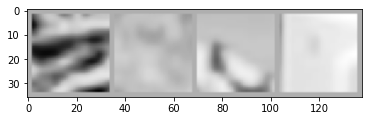

In [ ]:
# Default `log_dir` is "runs"
# Initalize a summary writer to store the log file of the program execution
writer = SummaryWriter('runs/SR_with_MSE_loss')

# Load the Tensor Dataset by shuffling it into in batches of size 4 images
# Drop the last batch as it might not be of size 4 (it can cause issue because of non-uniform size)
my_dataloader2 = data.DataLoader(my_training_dataset, batch_size=4, shuffle=True, drop_last=True)

# Get a set of random training images
dataiter = iter(my_dataloader2)

# Store the first image from the random image set
images, labels = dataiter.next()

# Initial 4-D Tensor of the required size with zeroes
images_2 = torch.zeros((4,3,32,32))

# Storing the images in the dimensions of the Tensor

# Storing the images in the First dimension of the Tensor
images_2[:,0,:,:] = images

# Storing the images in the Second dimension of the Tensor
images_2[:,1,:,:] = images

# Storing the images in the Third dimension of the Tensor
images_2[:,2,:,:] = images

# Create a grid of images with 4 rows
img_grid = torchvision.utils.make_grid(images_2, nrow=4)

# Plot the images in GreyScale using the above user-defined function
matplotlib_imshow(img_grid, one_channel=True)

# Write the images to the Tensorboard
writer.add_image('four_training_images', img_grid)

# Write the graph consisting of the plotted random images to the Tensorboard
writer.add_graph(SR_model, images.unsqueeze(1).float().to(device))

# Close the writer after the required data is stored
writer.close()

<font face = "Times New Roman">

Initialize variable to store the associated errors and inaccuracies of the model for the comprehensive error analysis

</font>

In [ ]:
# Per Epoch Evaluation using SSIM and PSNR 
epoch_eval= {
    'psnr_srcnn' : [],
    'psnr_bicubic' : [],
    'ssim_srcnn' : [],
    'ssim_bicubic' : []
}

<font face = "Times New Roman">

Training and validation of the dataset using the Super-Resolution CNN

</font>

In [ ]:
# psnr_bicubic, psnr_srcnn = [],[]

# (20 - global_epoch) as whenever we stop and re reun the cell we don't have again do 50 times but whatevers times is remaining
epochs_remaining = 20 - global_epoch
# epochs_remaining = 10 - global_epoch
SR_model.load_state_dict(torch.load( './models/SRCNN_3x.pt', map_location=torch.device('cpu')))
# Iterate over the dataset multiple times
for epoch in range(epochs_remaining):  

    # Check the current iteration
    print("epoch: ", global_epoch + 1)
    # imgarray = [[] for i in range(2000)]

    # As the model has not yet run, so it has no loss, initialized to zero
    running_loss = 0.0

    # Traverse through all the inputs in the Tensor with labels
    for batch_i, data in enumerate(my_dataloader, 0):

        # Get the inputs; data is a list of [inputs, labels]
        inputs, ground_truth = data

        # Attach the inputs to the default device
        inputs = inputs.float().to(device)
        ground_truth = ground_truth.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize

        # Fit the inputs in the ML model
        outputs = SR_model(inputs.unsqueeze(1))     

        # Estimate the loss with the criterion specified above (MSE)
        loss = criterion(outputs.squeeze(), ground_truth.float())
        
        # Back Propagation in the model for optimization
        loss.backward()

        # Carry forward the optimizer step by step
        optimizer.step()

        # Add the current loss to the running loss
        running_loss += loss.item()             

        # Print Statistics at the interval of every 10 mini-batches
        if batch_i % 100 == 99:

            # Printing the necessary components 
            print('[%d, %5d] loss: %.3f' %(global_epoch + 1, batch_i + 1, running_loss / 100))
            
            # Write the statistics in the log file for recovery in case the session crashes
            writer.add_scalar('training loss', running_loss / 100, global_epoch * len(my_dataloader) + batch_i)

            # As we have computed the loss in the current batch, we need to reset the value for the next batch 
            running_loss = 0.0
        
    # End of epoch metric calculations -> move to the next iteration (increment the iterator)
    global_epoch += 1

    # Error analysis computation for the batch
    with torch.no_grad():

        # Initialization of the validation loss and batch index iterator
        val_loss = 0
        batch_i = 0

        # Traverse through all the inputs in the Tensor with labels
        for batch_i, data in enumerate(my_val_dataloader, 0):

            # Get the inputs; data is a list of [inputs, labels]
            inputs, ground_truth = data

            # Attach the inputs to the default device
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize

            # Fit the inputs in the ML model
            outputs = SR_model(inputs.float().unsqueeze(1))
            
            # Estimate the loss with the criterion specified above (MSE)
            # Add the current loss to the running loss
            val_loss += criterion(outputs.squeeze(), ground_truth.float())
        
        # Get average loss per batch, to match how loss is reported in training
        val_loss = val_loss/(len(my_val_dataloader))

        # Log the value of the validation loss
        writer.add_scalar('validation loss', val_loss, global_epoch)

        # Print the value of the validation loss
        print('epoch %d validation loss: %f'%(global_epoch, val_loss))

        # Replace the best possible validation loss with the minimal validation loss (loss should be minimized)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            # As we have the lowest loss found, we are saving the variables and the model state
            print("New lowest loss found. Saving checkpoint.")

            # Saved in the checkpoint file containing model state and best validation loss value
            torch.save({'epoch': global_epoch,
                        'model_state_dict': SR_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val loss': val_loss
                        }, './checkpoint_SRCNN_w_MSE.pt')
        
        # Evaluate the model for an unrelated dataset to track PSNR
        # Refer to the documentation of the function in the source code
        mean_blur_psnr, mean_sr_psnr, mean_blur_ssim, mean_sr_ssim = evaluate_model(
                                                    path='./Data/Eval-BSDS200_Set5_Set14/', 
                                                    model=SR_model, 
                                                    pixel_mean=train_pixel_mean, 
                                                    pixel_std=train_pixel_std)
        # Note: evaluate_model was called when the default arg in the module
        # SR_FACTOR was initialized to 4 but it is set to three as directed by the paper
        
        #Appending Epoch PSNR and SSIM Values
        epoch_eval['psnr_bicubic'].append(mean_blur_psnr)
        epoch_eval['psnr_srcnn'].append(mean_sr_psnr)
        epoch_eval['ssim_bicubic'].append(mean_blur_ssim)
        epoch_eval['ssim_srcnn'].append( mean_sr_ssim)

        # Logging the data for fast recovery in the case of session crash
        writer.add_scalars('PSNR Evaluation over Set5, Set14 and BSDS200  (dB)', {'bicubic_psnr':mean_blur_psnr,
                                            'srcnn_psnr':mean_sr_psnr}, global_epoch)
        writer.add_scalars('SSIM Evaluation over Set5, Set14 and BSDS200  ', {'bicubic_ssim':mean_blur_ssim,
                                            'srcnn_ssim':mean_sr_ssim}, global_epoch)
        
        # Printing the errors in the necessary format
        print("PSNR Evaluation over Set5, Set14 and BSDS200 : Bicubic = %f ; SRCNN = %f"%(mean_blur_psnr, mean_sr_psnr))
        print("SSIM Evaluation over Set5, Set14 and BSDS200 : Bicubic = %f ; SRCNN = %f"%(mean_blur_ssim, mean_sr_ssim))

# As we have completed iterating over the dataset
print('Finished Training')

epoch:  1
[1,   100] loss: 0.054


KeyboardInterrupt: ignored

In [ ]:
writer.close()

<font face = "Times New Roman">

## Tierce 3

</font>

<font face = "Times New Roman">

Torch state import

<font face = "Times New Roman">

Preprocessing and Postprocessing are the folder where user-defined functions are stored on the drive

Importing the functions by name from the necessary files for direct use in the program.

</font>

In [ ]:
from Preprocessing.distort_images import distort_image
from Preprocessing.utils import ycbcr2rgb
from Preprocessing.utils import psnr
from Postprocessing.evaluation import evaluate_model, metric_values, cos
from Postprocessing.upsampling import get_image_crops, upsample_images
from Postprocessing.plots import evaluation_plot, loss_plot, upsampling_plot

In [ ]:
import cv2

SR_model
SR_model.load_state_dict(torch.load( './models/SRCNN_3x.pt', map_location=torch.device('cpu')))

NameError: ignored

<font face = "Times New Roman">

Reverse Pre-Processing 

In [ ]:
training_img_names = [i for i in os.listdir('./Data/BSDS500/images/test/') if i[-4:] in {'.png','.jpg','.bmp'} ]

for test_im in training_img_names :
    path = './Data/BSDS500/images/test/' + test_im
    blurred_test_im = distort_image(path=path, factor=SR_FACTOR, sigma=1, blur=True)
    ImageFile = Image.open(path)
    im = np.array(ImageFile.convert('YCbCr')) 
    
    #normalize
    input = blurred_test_im[:,:,0] / 255.0
    #standardize
    input -= train_pixel_mean
    input /= train_pixel_std
    im_out_Y = SR_model(torch.tensor(input, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device))
    im_out_Y = im_out_Y.detach().squeeze().squeeze().cpu().numpy().astype(np.float)
    im_out_viz = np.zeros((im_out_Y.shape[0], im_out_Y.shape[1], 3))
    
    #unstandardize 
    im_out_Y = (im_out_Y * train_pixel_std) + train_pixel_mean
    
    #un-normalize
    im_out_Y *= 255.0

    im_out_viz[:,:,0] = im_out_Y
    im_out_viz[:,:,1] = im[:,:,1]
    im_out_viz[:,:,2] = im[:,:,2]

    # Plotting graph
    f, axarr = plt.subplots(1,3, figsize=(20, 20))
    axarr[0].set_xlabel('Original / PSNR', fontsize=20)
    axarr[0].imshow(Image.fromarray(im, 'YCbCr'))

    axarr[1].set_xlabel('Bicubic / ' + str(np.around(psnr(im[:,:,0], blurred_test_im[:,:,0]),3)), fontsize=20)
    axarr[1].imshow(Image.fromarray(blurred_test_im, 'YCbCr'))
    
    axarr[2].set_xlabel('SRCNN / ' + str(np.around(psnr(im[:,:,0], im_out_viz[:,:,0]),3)), fontsize=20)
    # axarr[2].imshow((im_out_viz))
    axarr[2].imshow(ycbcr2rgb(im_out_viz))
    plt.show()

    tosave = './Test_SRCNN_Output/' + test_im

    # Use RGB Colour Space instead of default  BGR or BGRA of OPen CV
    cv2.imwrite(tosave, cv2.cvtColor(ycbcr2rgb(im_out_viz), cv2.COLOR_RGB2BGR))
print("Saving complete")

Output hidden; open in https://colab.research.google.com to view.

<font face = "Times New Roman">

Red - Blue Inversion - Open CV

In [ ]:
training_img_names = [i for i in os.listdir('./Data/BSDS500/images/test/') if i[-4:] in {'.png','.jpg','.bmp'} ]

for test_im in training_img_names :
    path = './Data/BSDS500/images/test/' + test_im
    blurred_test_im = distort_image(path=path, factor=SR_FACTOR, sigma=1, blur=True)
    ImageFile = Image.open(path)
    im = np.array(ImageFile.convert('YCbCr')) 
    
    #normalize
    input = blurred_test_im[:,:,0] / 255.0
    #standardize
    input -= train_pixel_mean
    input /= train_pixel_std
    im_out_Y = SR_model(torch.tensor(input, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device))
    im_out_Y = im_out_Y.detach().squeeze().squeeze().cpu().numpy().astype(np.float)
    im_out_viz = np.zeros((im_out_Y.shape[0], im_out_Y.shape[1], 3))
    
    #unstandardize 
    im_out_Y = (im_out_Y * train_pixel_std) + train_pixel_mean
    
    #un-normalize
    im_out_Y *= 255.0

    im_out_viz[:,:,0] = im_out_Y
    im_out_viz[:,:,1] = im[:,:,1]
    im_out_viz[:,:,2] = im[:,:,2]

    # # Plotting graph
    # f, axarr = plt.subplots(1,3, figsize=(20, 20))
    # axarr[0].set_xlabel('Original / PSNR', fontsize=20)
    # axarr[0].imshow(Image.fromarray(im, 'YCbCr'))

    # axarr[1].set_xlabel('Bicubic / ' + str(np.around(psnr(im[:,:,0], blurred_test_im[:,:,0]),3)), fontsize=20)
    # axarr[1].imshow(Image.fromarray(blurred_test_im, 'YCbCr'))
    
    # axarr[2].set_xlabel('SRCNN / ' + str(np.around(psnr(im[:,:,0], im_out_viz[:,:,0]),3)), fontsize=20)
    # # axarr[2].imshow((im_out_viz))
    # axarr[2].imshow(ycbcr2rgb(im_out_viz))
    # plt.show()

    tosave = './Red-Blue/' + test_im

    # Use RGB Colour Space instead of default  BGR or BGRA of OPen CV
    cv2.imwrite(tosave, ycbcr2rgb(im_out_viz))
print("Saving complete")

Saving complete


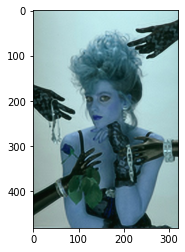

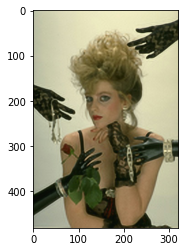

In [ ]:
correct_image = np.array(Image.open("./Red-Blue/198087.jpg"))
inverse_image = np.array(Image.open("./Test_SRCNN_Output/198087.jpg"))

plt.imshow(correct_image)
plt.show()
plt.imshow(inverse_image)
plt.show()


<font face = "Times New Roman">

Upsampled Image Plot

10 6
(321, 481, 3)


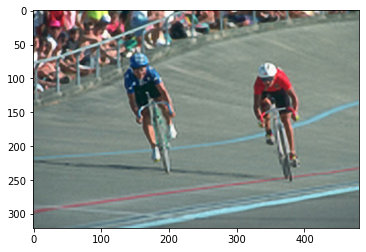

(321, 481, 3)


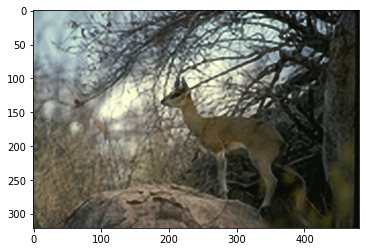

(481, 321, 3)


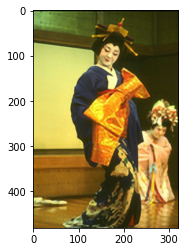

(321, 481, 3)


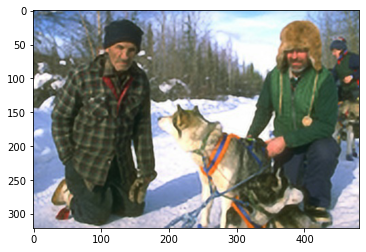

(321, 481, 3)


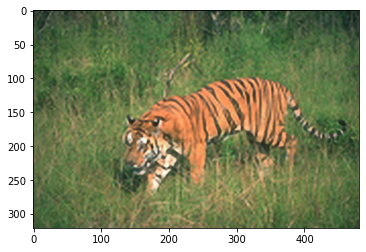

(481, 321, 3)


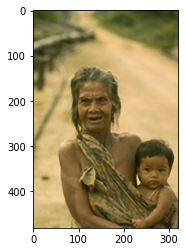

(321, 481, 3)


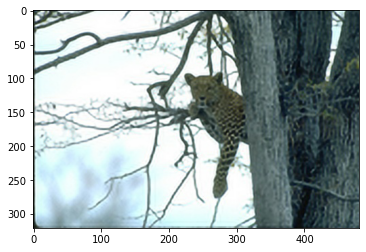

(321, 481, 3)


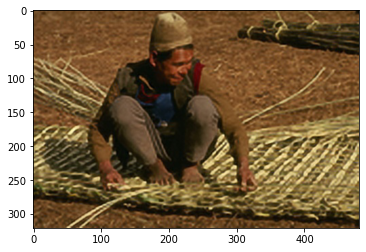

(321, 481, 3)


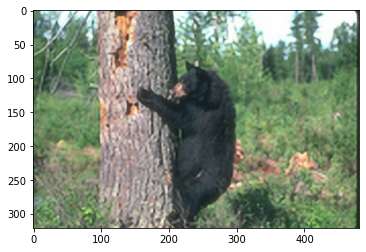

(321, 481, 3)


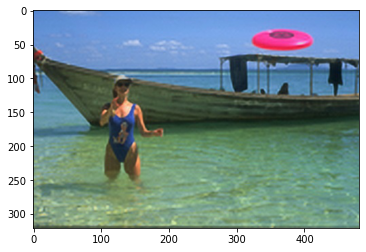

In [ ]:
image_compare = upsample_images("./Test_SRCNN_Output/", 10, 160, 160)
print(len(image_compare), len(image_compare[0][1]))

for image_index in range(len(image_compare)):
    print(image_compare[image_index][0].shape)
    plt.imshow(image_compare[image_index][0])
    plt.show()

(481, 321, 3)


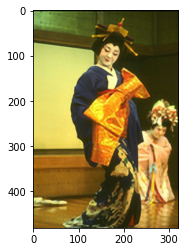

Original Crop (160, 160, 3)


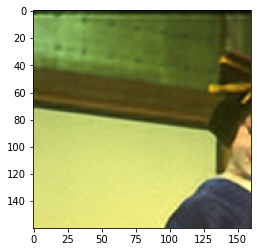

Upsampled Crop (481, 321, 3)


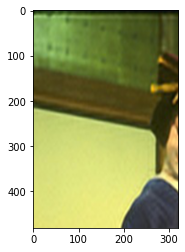

Original Crop (160, 160, 3)


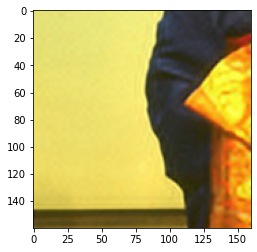

Upsampled Crop (481, 321, 3)


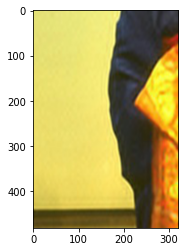

Original Crop (160, 160, 3)


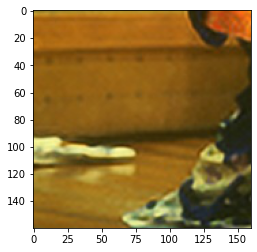

Upsampled Crop (481, 321, 3)


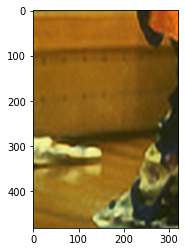

Original Crop (160, 160, 3)


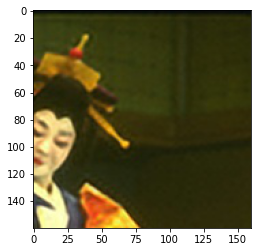

Upsampled Crop (481, 321, 3)


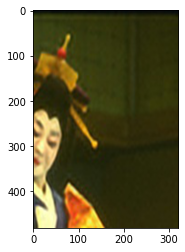

Original Crop (160, 160, 3)


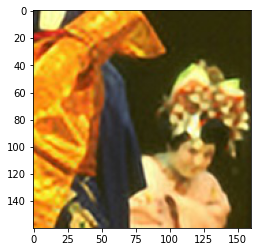

Upsampled Crop (481, 321, 3)


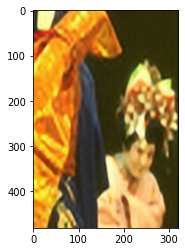

Original Crop (160, 160, 3)


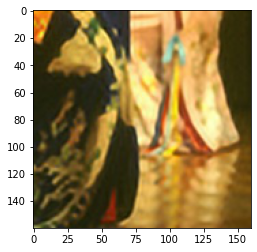

Upsampled Crop (481, 321, 3)


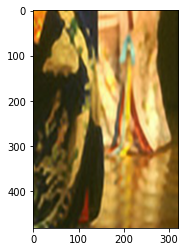

In [ ]:
print(image_compare[2][0].shape)
plt.imshow(image_compare[2][0])
plt.show()

for (original_crop, upsampled_crop) in zip(image_compare[2][1],image_compare[2][2]):
    print("Original Crop", original_crop.shape)
    plt.imshow(original_crop)
    plt.show()
    print("Upsampled Crop", upsampled_crop.shape)
    plt.imshow(upsampled_crop)
    plt.show()

In [ ]:
pip install image-similarity-measures

<font face = "Times New Roman">
Results 

In [ ]:
from image_similarity_measures.quality_metrics import fsim, issm, psnr, rmse, sam, sre, ssim, uiq

metric_results = metric_values(image_compare, [psnr, ssim, rmse, sre, sam, cos])
for i in range(len(metric_results)):
    print(f"Image {i + 1}")
    for key,value in metric_results[i].items():
        # print(f"{key} - {list(map(lambda x: round(x, ndigits=4), value))}")
        print(f"{key} - {value}")

    print()


/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:260: RuntimeWarning: invalid value encountered in true_divide
  val = np.clip(numerator / denominator, -1, 1)


Image 1
psnr - [40.867898499278596, 39.14791825941043, 39.73576072385745, 40.8547616355701, 39.23646453550296, 38.790521656779816]
ssim - [0.8800768344684115, 0.8556641623509454, 0.8465581806506858, 0.8846859889907824, 0.8492751219316972, 0.8160473854674017]
rmse - [0.009049092, 0.011030726, 0.010308892, 0.00906279, 0.010918848, 0.011494073]
sre - [45.63894224887463, 45.030926867668654, 44.94374052225844, 45.56906511259253, 44.890290137718964, 44.527010958199455]
sam - [85.99681963983153, 85.9150428311379, 86.315288756574, 87.37172245163302, 86.54040077205036, 85.55940725955492]
cos - [7.594140081788097e-08, 4.8026931432442915e-08, 4.126704921165863e-08, 4.540844113303519e-08, 1.1463932269894362e-07, 3.512061646618177e-08]

Image 2
psnr - [40.32202247312503, 42.21668723752933, 38.4943724029346, 38.79354003599124, 41.95256951978641, 41.14300969770389]
ssim - [0.851004127659354, 0.9168663614738063, 0.8394667892783453, 0.8223463103785374, 0.9105228343620285, 0.8772869580528138]
rmse - [0.

<font face = "Times New Roman">

Comprehensive Error Analysis

Graph Plotting

</font>

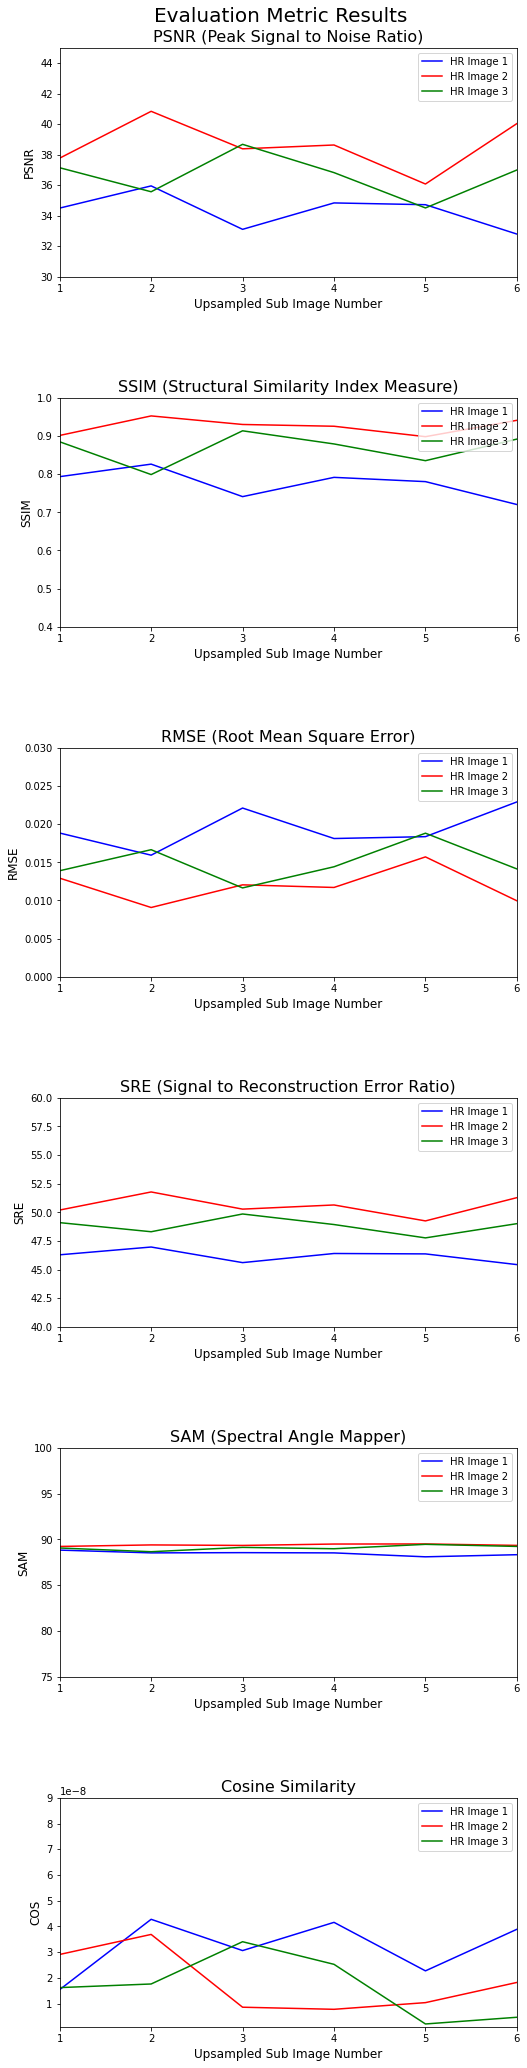

In [ ]:
upsampling_plot(metric_results)

<font face = "Times New Roman">

Different Crop Sizes

/usr/local/lib/python3.7/dist-packages/image_similarity_measures/quality_metrics.py:260: RuntimeWarning: invalid value encountered in true_divide
  val = np.clip(numerator / denominator, -1, 1)


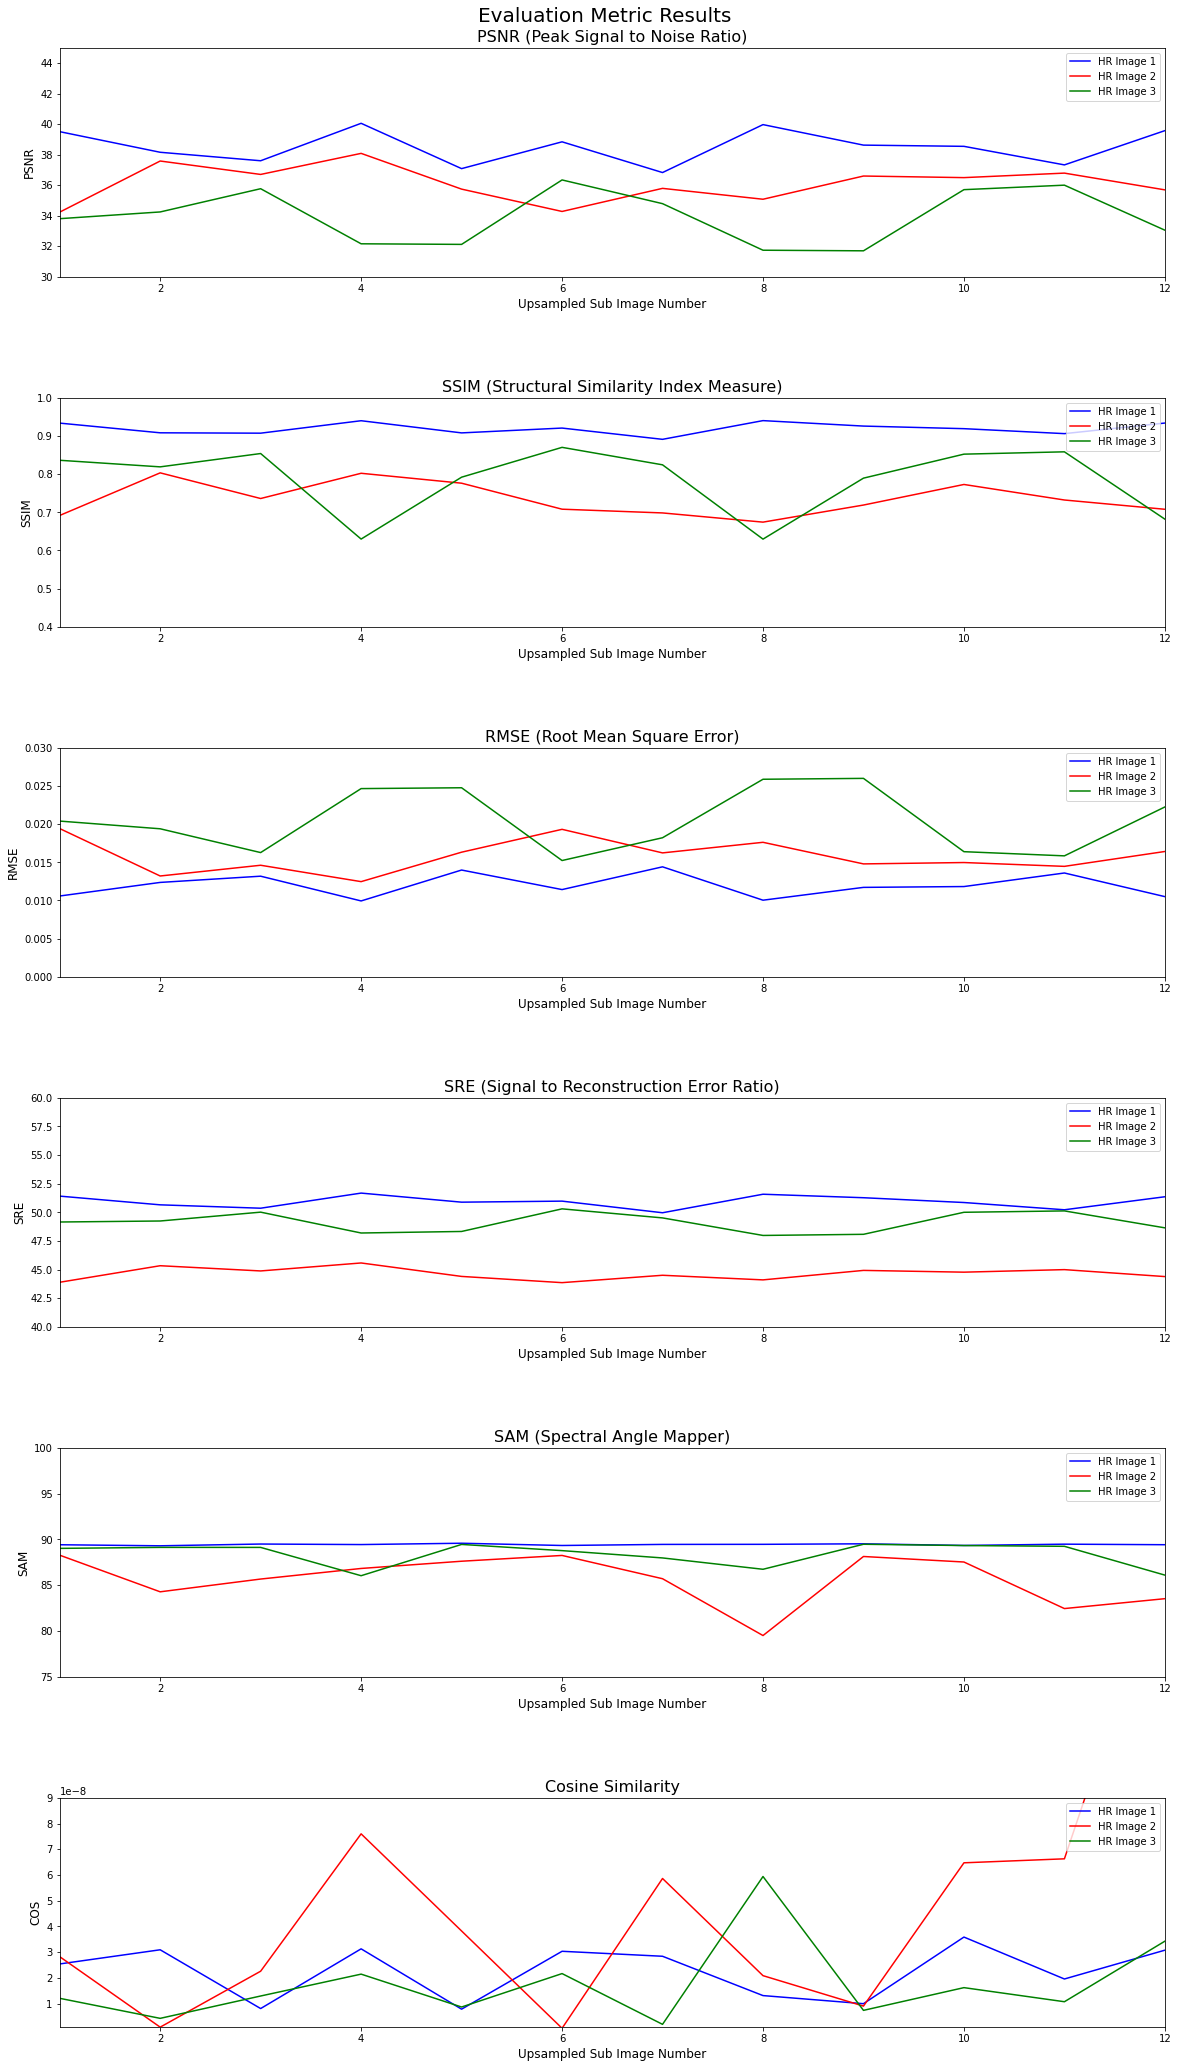

In [ ]:
upsampled_images_12 = upsample_images("./Test_SRCNN_Output/", 10, 80, 160)
metric_results_12 = metric_values(upsampled_images_12, [psnr, ssim, rmse, sre, sam, cos])
upsampling_plot(metric_results_12)

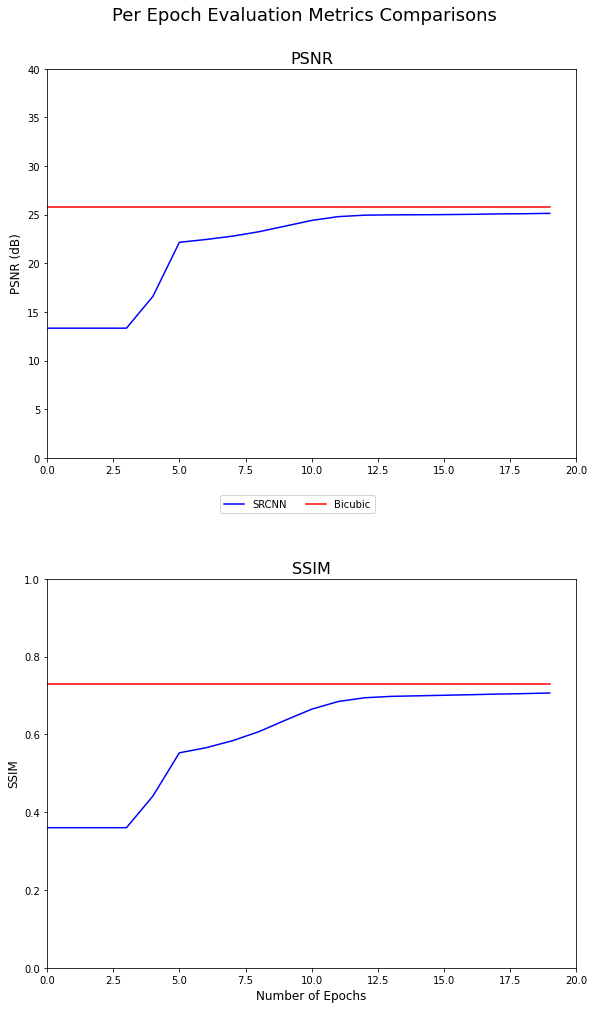

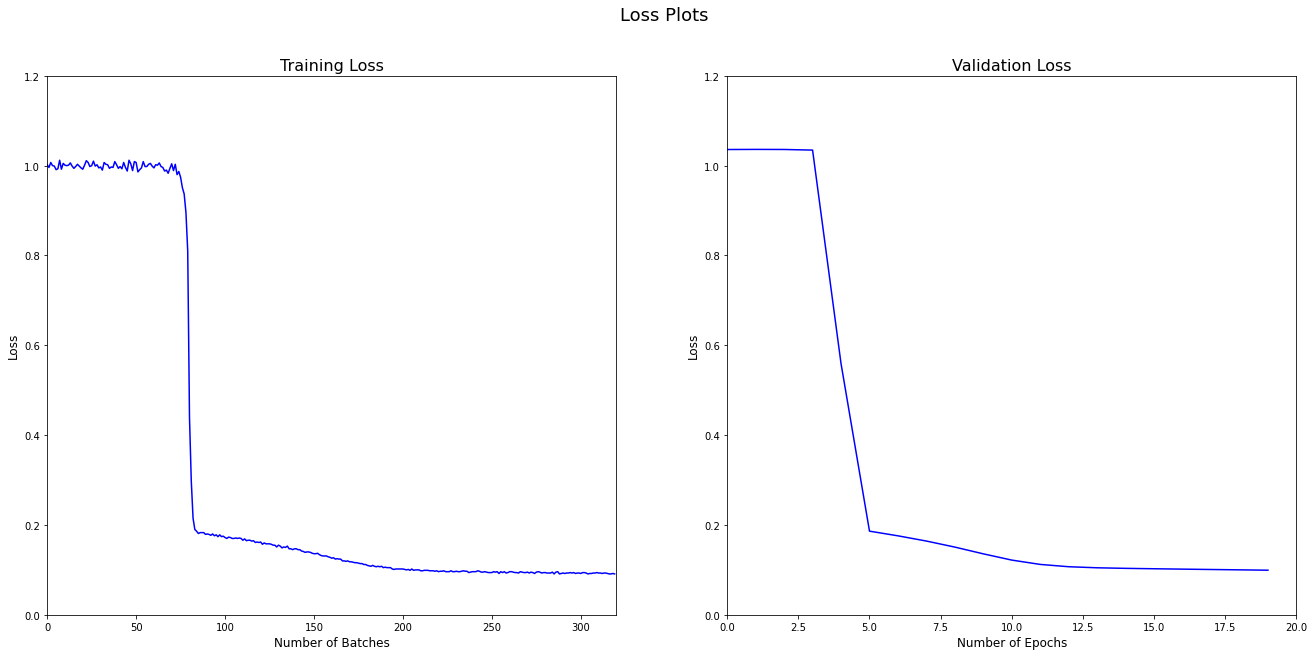

In [ ]:
evaluation_plot()
print()
loss_plot()

<font face = "Times New Roman">
Requirements 

In [ ]:
pip freeze > check.txt

In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1GUOQrepVzg4gs_71w3YXQho20ypXw2ud/SRCNN_FDPL_sdv4
